<a href="https://colab.research.google.com/github/gavin-bauer/recode-core-ml-from-scratch/blob/master/shallow-nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recoding a one hidden layer neural network

#### Synopsis
In order to understand the details of the most frequent algorithms in Machine Learning, I have recoded the core concepts in Python using only Numpy (for computations) and Matplotlib (for visualizations).

#### In this post
I re-implement the main components of a one hidden layer neural network.

#### NB
It is recommended that the reader is familiar with fundamental machine learning concepts such as _features_, _target_, _parameters_, _learning rate_, etc...

## Goal
Build a shallow neural network (nn) capable of fitting a "flower" 2-class dataset. Therefore demonstrating how nn are able to fit more complex data compared to logistic regression.

1. Create a "flower" 2-class dataset with purple (y=0) and yellow (y=1) points.

2. Pass the data through the algorithm. 

3. The algorithm outputs a value between 0 and 1, which will be treated as the estimated probability that $y = 1$ on input x, which can be written as:

$$P(y=1 | x ; \theta)$$

**The steps can be better visualized in the image below**

<img src="https://raw.githubusercontent.com/Kulbear/deep-learning-coursera/997fdb2e2db67acd45d29ae418212463a54be06d/Neural%20Networks%20and%20Deep%20Learning/images/classification_kiank.png" style="width:650px;height:400px;">
_Credits: Coursera_


## 1 - Import packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 2 - Helper functions

In [0]:
def load_dataset():
    """
    credits: coursera
    """
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [0]:
def plot_dataset(X, Y):
    """
    Plot an image of the dataset. 

    Arguments:
    x -- A numpy array representing features
    y -- A numpy array representing the labels

    Return:
    Plot
    """
    
    plt.scatter(X[0], X[1], c=Y)
    plt.show()

In [0]:
def get_info(X, Y):
    print("number of training examples:", X.shape[1])
    print("shape of X:", X.shape)
    print("shape of Y:", Y.shape)

In [0]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1 / (1 + np.exp(-z))
    
    return s

In [0]:
def plot_learning_curve(costs):
    costs = np.squeeze(costs)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.show()

In [0]:
def plot_decision_boundary(model, X, y):
    """
    credits: coursera
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y)

## 3 - Load, explore and preprocess the dataset

Each line in `X` represents 2 features of a single instance.

Each line `Y` is represents the class of a single instance.

In [0]:
# Load dataset
X, Y = load_dataset()

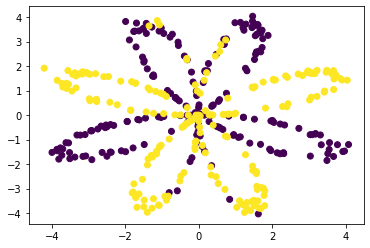

In [0]:
# Example of a picture
plot_dataset(X, Y)

In [0]:
# Explore dataset
get_info(X, Y)

number of training examples: 400
shape of X: (2, 400)
shape of Y: (1, 400)


## 4 - Build the model's components

The main steps for building a nn are:

1. Define the nn structure (number of inputs, number of hidden layers, etc...)

2. Initialize the model's parameters ( \\( \theta \\) )

3. Loop:
    - Implement forward propagation 
    - Compute loss 
    - Implement backward propagation
    - Update parameters (gradient descent)

#### 4.1 Define the nn's structure

The nn being implemented is a one hidden layer nn, with 4 units.

In [0]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

#### 4.2. Initialize the parameters

* $W$ is a parameter matrix, randomly initialized
* $b$ is a vector, initialized with a zero

In [0]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- dictionary containing the parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
        
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 4.3 - Loop: forward and backward propagation and update parameters

Implement the "forward" and "backward" propagation steps for learning the parameters iteratively, using gradient descent.

#### 4.3.1 Forward Propagation

For one example ( \\( x^{(i)} \\) ) and a single iteration, the forward pass can be mathematically represented in the four steps as follow:

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$


In [0]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- dictionary containing the parameters (output of initialization function)
    
    Returns:
    A2 -- the sigmoid output of the second activation
    cache -- dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

#### 4.3.2 Compute cost

Now that $A^{[2]}$ (which contains $a^{[2](i)}$ for every example) has been computed, the cost function can be calculated as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small$$


In [0]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    
    cost = np.squeeze(cost)

    assert(isinstance(cost, float))
    
    return cost

####4.3.3 Back propagation

Finetune the parameters by computing the gradient of the loss function with respect to the parameters.

Mathematically, this is expressed as:

<img src="https://github.com/gavin-bauer/blog/blob/master/static/images/Shallow-nn/grads-formulas.png" style="width:600px;height:300px;">
_Credits: Coursera_

In [0]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- dictionary containing our parameters 
    cache -- dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]

    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    
    dZ2= A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

#### 4.3.3 The optimization function

In order to find the best parameters that minize the cost function, the parameters will be updated iteratively using an algorithm called "Gradient Descent".

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [0]:
def update_parameters(parameters, grads, learning_rate=1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- dictionary containing your parameters 
    grads -- dictionary containing your gradients 
    
    Returns:
    parameters -- dictionary containing your updated parameters 
    """

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

#### 4.4 Bring everything together

In [0]:
def build_nn(X, Y, n_h, num_iterations=10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    costs = []

    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)     
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
            costs.append(cost)

    return parameters, costs

Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220621


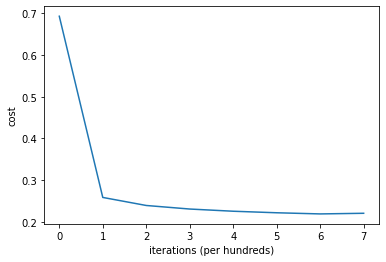

In [0]:
parameters, costs = build_nn(X, Y, 4, num_iterations=8000, print_cost=True)
plot_learning_curve(costs)

## 5 - Predictions

Using the learned parameters, it is possible to predict the labels (denoted $\hat{Y}$) for a dataset X. The algorithm outputs a value between 0 and 1, which should be treated as the estimated probability that $y = 1$ on input x, which can be written as:

$$\hat{Y} = P(y=1 | x ; \theta)$$

By setting a threshold at 0.5, it would be possible to declare the following:

$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}$$

In [0]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    
    return predictions

Accuracy: 90%


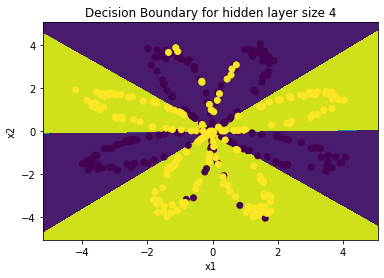

In [0]:
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

**Comment**: 
* Accuracy is really high as the model has learnt the leaf patterns of the flower! 
* Loss drops sharply after first 1,000 iterations, before diminishing more slowly going forward.
* Compared to Logistic Regression, nn are able to learn even highly non-linear decision boundaries.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


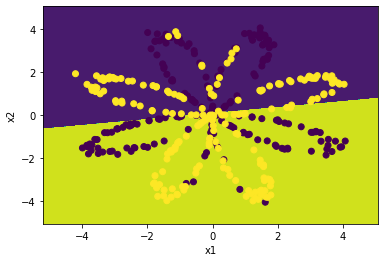

In [0]:
from sklearn import linear_model

log_reg = linear_model.LogisticRegression()
log_reg.fit(X.T, Y.T)
plot_decision_boundary(lambda x: log_reg.predict(x), X, Y)